### Libraries and imports

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.io import read_image
from torch.autograd import Variable
from torchvision.ops import SqueezeExcitation
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from torchsummary import summary
import matplotlib.pyplot as plt
import math
import time
import random
import csv
import pandas as pd
import matplotlib as mpl
%matplotlib inline

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device:', device)

TRAIN = True

device: cuda


In [ ]:
os.chdir('../')

In [9]:
from lib.data.dataset import MixDepth, read_fnames
from lib.losses.losses import PELoss, RMSLELoss, multiscale_loss
from lib.model.RT_distr_v2_conv1x1 import RT_MonoDepth_Mk2
from lib.utils.plotters import *
from lib.utils.train_tools import Trainer

### Dataset and Dataloaders

In [4]:
if device.type == 'cuda' and TRAIN:
    inmemory = True
else:
    inmemory = False
fnames_tr = read_fnames('data/nyu2_train.csv')
fnames_tr, fnames_vl = train_test_split(fnames_tr, train_size=0.8, shuffle=True)

ds_tr = MixDepth(fnames_tr, device=device, mode='train', inmemory=inmemory)
ds_vl = MixDepth(fnames_vl, device=device, mode='val', inmemory=inmemory)

batch_size = 32
num_workers = 0 #if inmemory else 2

In [5]:
data_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, num_workers=num_workers) #, pin_memory=inmemory, pin_memory_device=device)
data_vl = DataLoader(ds_vl, batch_size=batch_size, shuffle=False, num_workers=num_workers) #, pin_memory=inmemory, pin_memory_device=device)

### Pictures and depth

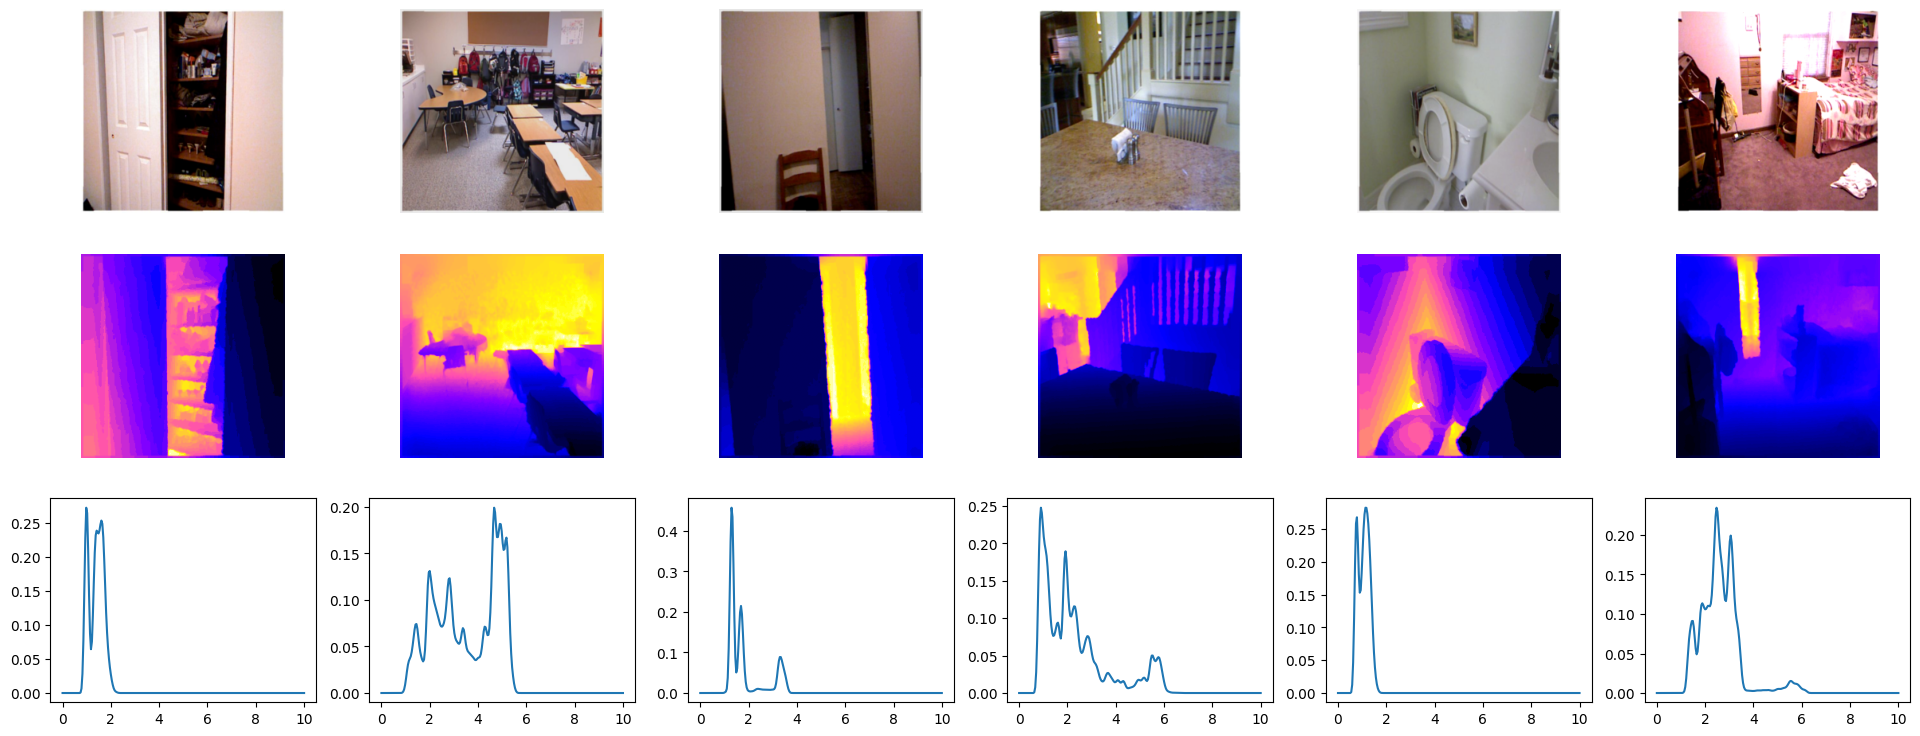

In [6]:
rgb, depth, distr = next(iter(data_tr))

N = min(batch_size, 6)

plt.figure(figsize=(24, 9))

def plot_pair(rgb, depth, distr, i):
  plt.subplot(3, N, i)
  plt.imshow(torch_to_img(rgb))
  plt.axis('off')
  plt.subplot(3, N, i + N)
  plt.imshow(depth[0].detach().cpu(), cmap='gnuplot2')
  plt.axis('off')
  plt.subplot(3, N, i + 2 * N)
  plt.plot(np.linspace(0, 10, 256), distr.cpu())

for i in range(N):
  rgb_, depth_, distr_ = rgb[i], depth[i], distr[i]
  plot_pair(rgb_, depth_, distr_, i + 1)

plt.show()

#### Weights normalization


In [7]:
def weights_init_normal(m):
  if not hasattr(m, 'weight'):
    return
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

#### Model initialization

In [8]:
model = RT_MonoDepth_Mk2(decode_distr=True)
model.apply(weights_init_normal)
model.to(device)
rgb, depth, distr = next(iter(data_tr))
model.eval()
out_1 = model(rgb.to(device))
out_1.shape

torch.Size([32, 1, 256, 256])

### Training

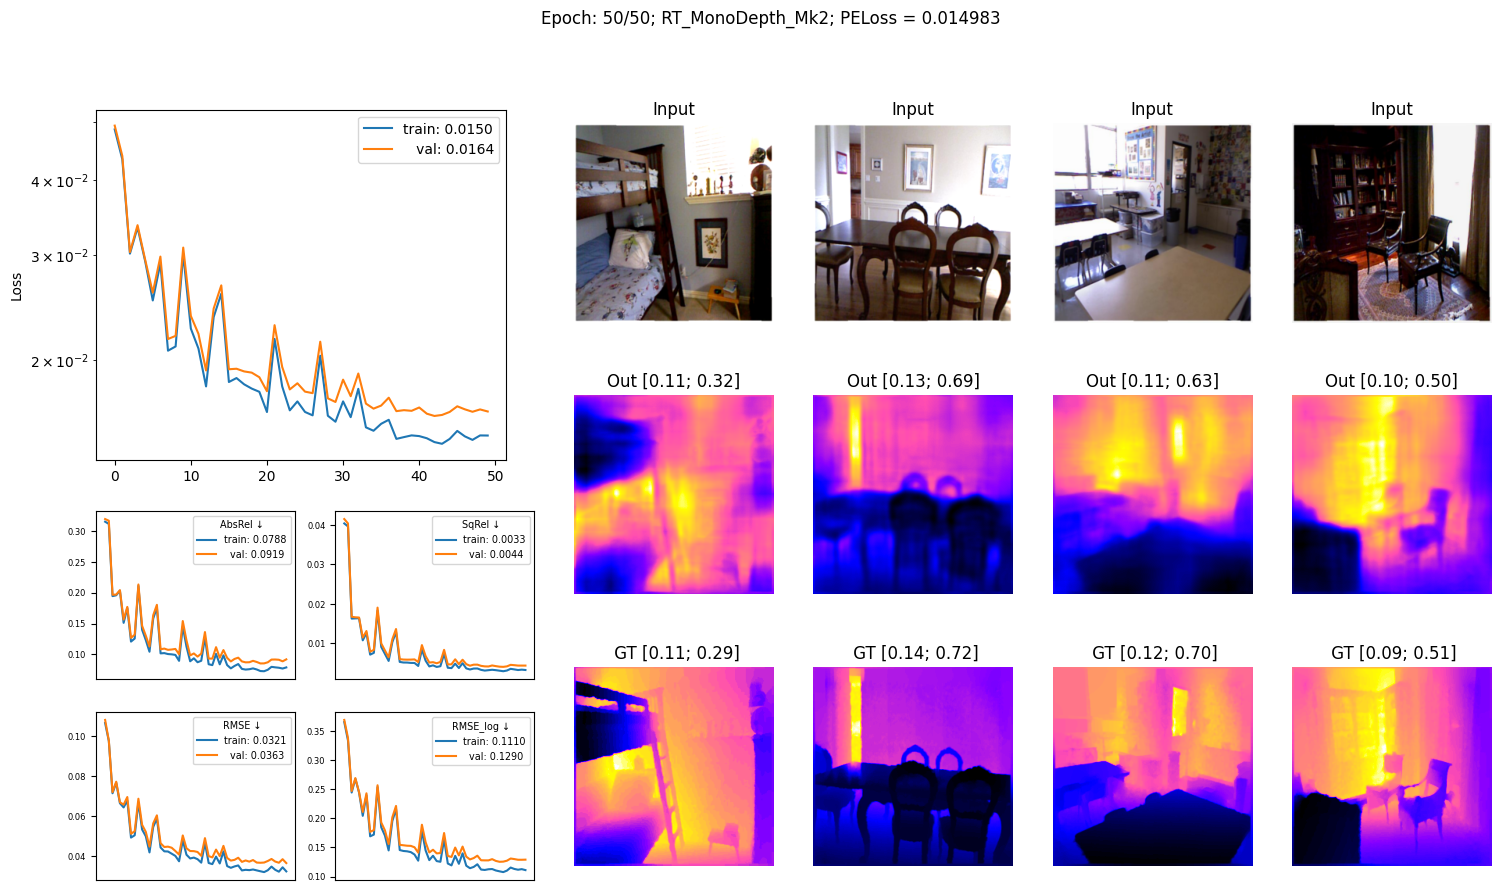

   T: 4743.626203298569
time: 4290.8984978199005


In [ ]:
epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=5, gamma=0.8)

criterion = PELoss()
criterion_d = RMSLELoss()

train_loop = Trainer(model, optimizer, criterion, criterion_d, multiscale_loss, epochs, data_tr, data_vl, .2, scheduler)


if TRAIN:
  history_rtmd_pe = train_loop.train()